In [1]:
#!/bin/python3
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
import copy

### statisitcs with uncertainties for charge changing with geometric corrections

In [2]:
def stat_errors_charge(filename_cc,geo_corr_file,target_thickness,adding):
    targettype = None
    factor = None
    n_t = None
    delta_n_t = None
    new_density = 1.851
    T_2198 = (new_density)*(2.1928)*(6.02214076)*(pow(10,23))/(12.011);
    T_1086 = (new_density)*(1.0793)*(6.02214076)*(pow(10,23))/(12.011);
    T_54 = (new_density)*(0.5451)*(6.02214076)*(pow(10,23))/(12.011);
    if (target_thickness == "thin"):
        targettype = "c_54"
        factor = (1./T_54)*(pow(10,27))
        n_t = T_54
        delta_n_t = 0.000648
    if (target_thickness == "medium"):
        targettype = "c_1086"
        n_t = T_1086
        delta_n_t = 0.002620
        factor = (1./T_1086)*(pow(10,27))
    if (target_thickness == "thick"):
        targettype = "c_2198"
        n_t = T_2198
        delta_n_t = 0.000322
        factor = (1./T_2198)*(pow(10,27))
        
    ##data frame for charge changing
    df_cc = pd.read_csv(filename_cc,sep='\t',names=["datatype","targettype","RunID","energy","incoming ions","survived_ions"])
    df_cc["d_carbon_survived"] = df_cc["survived_ions"]/df_cc["incoming ions"]
    ##data frame for geo correction
    df_geo = pd.read_csv(geo_corr_file,sep='\t',names=["datatype","targettype","RunID","energy","geo_corr_factor"])
    ### this step of doing the inverse is just needed for twim eff numbers!! DANGEROUS!
    df_geo["geo_corr_factor"] = 1./df_geo["geo_corr_factor"]
    #df_geo["geo_corr_factor"] = df_geo["geo_corr_factor"]

    cc_error_val = []
    cc_cs = []
    cc_cs_geo = []
    energy_vals = ["400","550","650","800"]
    for ene in energy_vals:
        #charge changing cross section
        dz = (float(df_cc.loc[(df_cc["targettype"] == targettype) & (df_cc["energy"] == float(ene))]['d_carbon_survived']))/(float(df_cc.loc[(df_cc["targettype"] == "empty") & (df_cc["energy"] == float(ene))]['d_carbon_survived']))
        cc = factor*(-math.log(dz))
        cc_cs.append(cc)
        #geo corr cross section
        d_geo = float(df_geo.loc[(df_geo["targettype"] == targettype)& (df_geo["energy"] == float(ene))]["geo_corr_factor"])/float(df_geo.loc[(df_geo["targettype"] == "empty")& (df_geo["energy"] == float(ene))]["geo_corr_factor"])
        cs_geo = factor*(-math.log(d_geo))
        if (adding =="true"):
            cc_cs_geo.append(cc+cs_geo) 
            #print("hellooo")
        if (adding == "false"):
            cc_cs_geo.append(cc)
            #print("not hello")

        ##now doing the stat. uncertainty calculations
        
        ### target thickness uncertainty
        target_error = pow(cc*delta_n_t,2)
        print("this is the target thickness",target_thickness)
        #print("this is the target error",target_error)

        ### charge changing uncertainties
        r_cc_target = float(df_cc.loc[(df_cc["targettype"] == targettype) & (df_cc["energy"] == float(ene))]['d_carbon_survived'])
        r_cc_empty = float(df_cc.loc[(df_cc["targettype"] == "empty") & (df_cc["energy"] == float(ene))]['d_carbon_survived'])
        n_i_t_cc = float(df_cc.loc[(df_cc["targettype"] == targettype) & (df_cc["energy"] == float(ene))]['incoming ions'])
        n_i_e_cc = float(df_cc.loc[(df_cc["targettype"] == "empty") & (df_cc["energy"] == float(ene))]['incoming ions'])
        cc_error = (pow(10,54))*(1./(n_t*n_t))*((1-r_cc_target)/(r_cc_target*n_i_t_cc)+(1-r_cc_empty)/(r_cc_empty*n_i_e_cc))
        #print("error of cc_error squared:\t",cc_error)
        cc_error_val.append(math.sqrt(target_error+cc_error))
        print("this is the target + cc error:t",math.sqrt(target_error+cc_error))

    return cc_cs_geo,cc_error_val

### here I use as geometric correction the twim efficiency factor
---

In [3]:
filename_cc = 'numbers/comb_gauss2d_border.txt' 
filename_geo_corr = "total_eff_twim.txt"

cc_cs_geo_thin,cc_geo_error_thin = stat_errors_charge(filename_cc,filename_geo_corr,"thin",'true')
cc_cs_geo_medium,cc_geo_error_medium = stat_errors_charge(filename_cc,filename_geo_corr,"medium",'true')
cc_cs_geo_thick,cc_geo_error_thick = stat_errors_charge(filename_cc,filename_geo_corr,"thick",'true')


cc_cs_geo_thin_f,cc_geo_error_thin_f = stat_errors_charge(filename_cc,filename_geo_corr,"thin",'false')
cc_cs_geo_medium_f,cc_geo_error_medium_f = stat_errors_charge(filename_cc,filename_geo_corr,"medium",'false')
cc_cs_geo_thick_f,cc_geo_error_thick_f = stat_errors_charge(filename_cc,filename_geo_corr,"thick",'false')


this is the target thickness thin
this is the target + cc error:t 7.296158629414295
this is the target thickness thin
this is the target + cc error:t 8.18441789437902
this is the target thickness thin
this is the target + cc error:t 7.696093902201342
this is the target thickness thin
this is the target + cc error:t 8.32941247228232
this is the target thickness medium
this is the target + cc error:t 4.803617207249372
this is the target thickness medium
this is the target + cc error:t 5.498511843225423
this is the target thickness medium
this is the target + cc error:t 5.261345367200519
this is the target thickness medium
this is the target + cc error:t 6.16434739265878
this is the target thickness thick
this is the target + cc error:t 2.763684659603712
this is the target thickness thick
this is the target + cc error:t 3.381974520106645
this is the target thickness thick
this is the target + cc error:t 3.106554482818948
this is the target thickness thick
this is the target + cc error:t 3

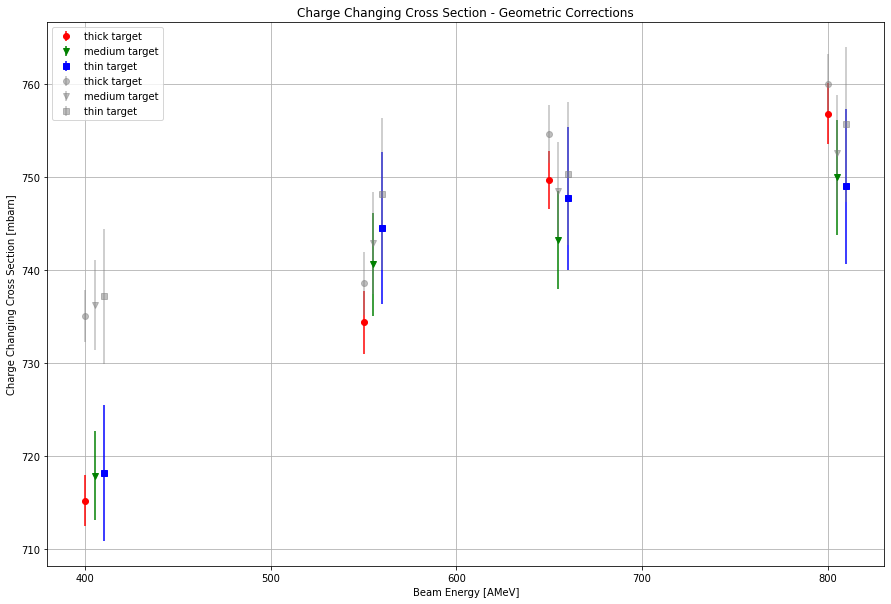

In [4]:
fig, ax = plt.subplots(figsize=(15,10))
#fig.tight_layout()
energy = [400,550,650,800]
ax.errorbar(energy,cc_cs_geo_thick,yerr=cc_geo_error_thick,label="thick target",color='red',marker="o",fmt="o")

energy = [405,555,655,805]
ax.errorbar(energy,cc_cs_geo_medium,yerr=cc_geo_error_medium,label="medium target",color='green',marker="v",fmt="o")

energy = [410,560,660,810]
ax.errorbar(energy,cc_cs_geo_thin,yerr=cc_geo_error_thin,label="thin target",color='blue',marker="s",fmt="o")

## whithout geo correction , in gray
energy = [400,550,650,800]
ax.errorbar(energy,cc_cs_geo_thick_f,yerr=cc_geo_error_thick_f,label="thick target",color='gray',marker="o",fmt="o",alpha=0.5)

energy = [405,555,655,805]
ax.errorbar(energy,cc_cs_geo_medium_f,yerr=cc_geo_error_medium_f,label="medium target",color='gray',marker="v",fmt="o",alpha=0.5)

energy = [410,560,660,810]
ax.errorbar(energy,cc_cs_geo_thin_f,yerr=cc_geo_error_thin_f,label="thin target",color='gray',marker="s",fmt="o",alpha=0.5)

ax.legend()
ax.grid()
ax.set_xlabel("Beam Energy [AMeV]")
ax.set_ylabel("Charge Changing Cross Section [mbarn]")
ax.set_title("Charge Changing Cross Section - Geometric Corrections")
#ax.set_ylim(740,890)
plt.savefig("charge_changing_cross_sec_twim_eff_corr.png",dpi=300)

---

### here I use as geo correction the real geo cuts...
---

In [5]:
filename_cc = 'numbers/comb_gauss2d_border.txt'
filename_geo_corr = "orig_geo_corr_factor.txt"

cc_cs_geo_thin,cc_geo_error_thin = stat_errors_charge(filename_cc,filename_geo_corr,"thin",'true')
cc_cs_geo_medium,cc_geo_error_medium = stat_errors_charge(filename_cc,filename_geo_corr,"medium",'true')
cc_cs_geo_thick,cc_geo_error_thick = stat_errors_charge(filename_cc,filename_geo_corr,"thick",'true')


cc_cs_geo_thin_f,cc_geo_error_thin_f = stat_errors_charge(filename_cc,filename_geo_corr,"thin",'false')
cc_cs_geo_medium_f,cc_geo_error_medium_f = stat_errors_charge(filename_cc,filename_geo_corr,"medium",'false')
cc_cs_geo_thick_f,cc_geo_error_thick_f = stat_errors_charge(filename_cc,filename_geo_corr,"thick",'false')

this is the target thickness thin
this is the target + cc error:t 7.296158629414295
this is the target thickness thin
this is the target + cc error:t 8.18441789437902
this is the target thickness thin
this is the target + cc error:t 7.696093902201342
this is the target thickness thin
this is the target + cc error:t 8.32941247228232
this is the target thickness medium
this is the target + cc error:t 4.803617207249372
this is the target thickness medium
this is the target + cc error:t 5.498511843225423
this is the target thickness medium
this is the target + cc error:t 5.261345367200519
this is the target thickness medium
this is the target + cc error:t 6.16434739265878
this is the target thickness thick
this is the target + cc error:t 2.763684659603712
this is the target thickness thick
this is the target + cc error:t 3.381974520106645
this is the target thickness thick
this is the target + cc error:t 3.106554482818948
this is the target thickness thick
this is the target + cc error:t 3

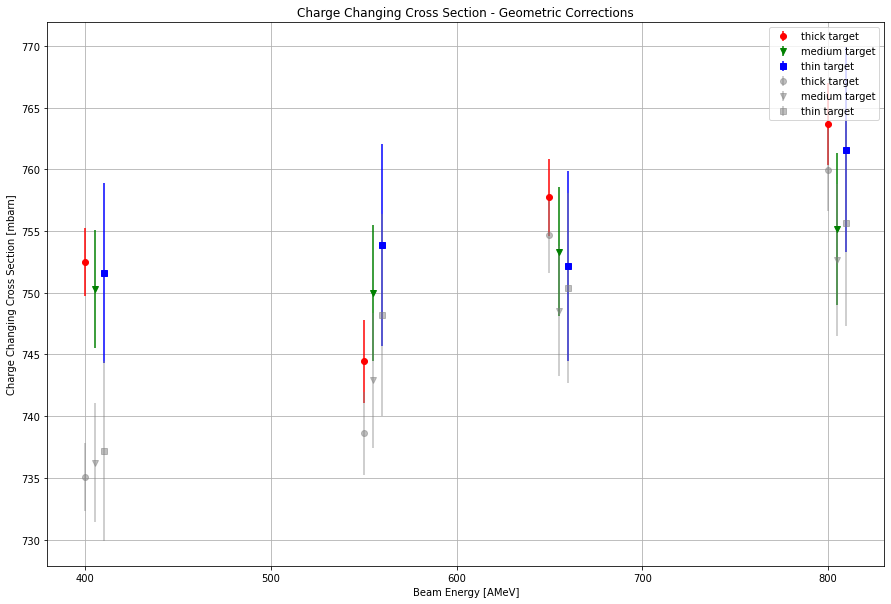

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
#fig.tight_layout()
energy = [400,550,650,800]
ax.errorbar(energy,cc_cs_geo_thick,yerr=cc_geo_error_thick,label="thick target",color='red',marker="o",fmt="o")

energy = [405,555,655,805]
ax.errorbar(energy,cc_cs_geo_medium,yerr=cc_geo_error_medium,label="medium target",color='green',marker="v",fmt="o")

energy = [410,560,660,810]
ax.errorbar(energy,cc_cs_geo_thin,yerr=cc_geo_error_thin,label="thin target",color='blue',marker="s",fmt="o")

## whithout geo correction , in gray
energy = [400,550,650,800]
ax.errorbar(energy,cc_cs_geo_thick_f,yerr=cc_geo_error_thick_f,label="thick target",color='gray',marker="o",fmt="o",alpha=0.5)

energy = [405,555,655,805]
ax.errorbar(energy,cc_cs_geo_medium_f,yerr=cc_geo_error_medium_f,label="medium target",color='gray',marker="v",fmt="o",alpha=0.5)

energy = [410,560,660,810]
ax.errorbar(energy,cc_cs_geo_thin_f,yerr=cc_geo_error_thin_f,label="thin target",color='gray',marker="s",fmt="o",alpha=0.5)

ax.legend()
ax.grid()
ax.set_xlabel("Beam Energy [AMeV]")
ax.set_ylabel("Charge Changing Cross Section [mbarn]")
ax.set_title("Charge Changing Cross Section - Geometric Corrections")
#ax.set_ylim(740,890)
plt.savefig("charge_changing_cross_sec_geo_cut_corr_with_fits.png",dpi=300)

## now this section is with flipping x and y to get the geo corrections + more sophisticated error vals = stat + syst

----

In [7]:
def charge_changing_geo_corr_flip(filename_cc,geo_corr_file,target_thickness,adding):
    targettype = None
    factor = None
    n_t = None
    delta_n_t = None
    new_density = 1.851
    T_2198 = (new_density)*(2.1928)*(6.02214076)*(pow(10,23))/(12.011);
    T_1086 = (new_density)*(1.0793)*(6.02214076)*(pow(10,23))/(12.011);
    T_54 = (new_density)*(0.5451)*(6.02214076)*(pow(10,23))/(12.011);
    if (target_thickness == "thin"):
        targettype = "c_54"
        factor = (1./T_54)*(pow(10,27))
        n_t = T_54
        delta_n_t = 0.000648
    if (target_thickness == "medium"):
        targettype = "c_1086"
        n_t = T_1086
        delta_n_t = 0.002620
        factor = (1./T_1086)*(pow(10,27))
    if (target_thickness == "thick"):
        targettype = "c_2198"
        n_t = T_2198
        delta_n_t = 0.000322
        factor = (1./T_2198)*(pow(10,27))
        
    ##data frame for charge changing
    df_cc = pd.read_csv(filename_cc,sep='\t',names=["datatype","targettype","RunID","energy","incoming ions","survived_ions"])
    df_cc["d_carbon_survived"] = df_cc["survived_ions"]/df_cc["incoming ions"]
    ##data frame for geo correction
    df_geo = pd.read_csv(geo_corr_file,sep='\t',names=["datatype","targettype","RunID","energy","x_corr_min","x_corr_max","y_corr_min","y_corr_max"])
    ### this step of doing the inverse is just needed for twim eff numbers!! DANGEROUS!
    df_geo["x_mean"] = 0.5* (df_geo["x_corr_min"] + df_geo["x_corr_max"])
    df_geo["y_mean"] = 0.5* (df_geo["y_corr_min"] + df_geo["y_corr_max"])
    df_geo["x_err"] = abs(0.5* (df_geo["x_corr_min"] - df_geo["x_corr_max"]))
    df_geo["y_err"] = abs(0.5* (df_geo["y_corr_min"] - df_geo["y_corr_max"]))
    df_geo["tot_corr"] = df_geo["x_mean"]*df_geo["y_mean"]
    df_geo["corr_error"] = (np.power(df_geo["x_mean"] * 0.5* (df_geo["y_corr_min"] - df_geo["y_corr_max"]),2) + np.power(df_geo["y_mean"] * 0.5* (df_geo["x_corr_min"] - df_geo["x_corr_max"]),2))
    #df_geo["geo_corr_factor"] = 1./df_geo["geo_corr_factor"]
                             
    
    cc_error_val = []
    cc_cs = []
    cc_cs_geo = []
    energy_vals = ["400","550","650","800"]
    for ene in energy_vals:
        #charge changing cross section
        dz = (float(df_cc.loc[(df_cc["targettype"] == targettype) & (df_cc["energy"] == float(ene))]['d_carbon_survived']))/(float(df_cc.loc[(df_cc["targettype"] == "empty") & (df_cc["energy"] == float(ene))]['d_carbon_survived']))
        cc = factor*(-math.log(dz))
        cc_cs.append(cc)
        #geo corr cross section

        print(df_geo.loc[(df_geo["energy"] == float(ene))]["tot_corr"])
        d_geo = float(df_geo.loc[(df_geo["targettype"] == targettype)& (df_geo["energy"] == float(ene))]["tot_corr"])/float(df_geo.loc[(df_geo["targettype"] == "empty")& (df_geo["energy"] == float(ene))]["tot_corr"])
        # error calculation for d_geo
        d_g_err_x_t = float(df_geo.loc[(df_geo["targettype"] == targettype)& (df_geo["energy"] == float(ene))]["x_err"])/float(df_geo.loc[(df_geo["targettype"] == targettype)& (df_geo["energy"] == float(ene))]["x_mean"])
        d_g_err_y_t = float(df_geo.loc[(df_geo["targettype"] == targettype)& (df_geo["energy"] == float(ene))]["y_err"])/float(df_geo.loc[(df_geo["targettype"] == targettype)& (df_geo["energy"] == float(ene))]["y_mean"])
      
        d_g_err_x_e = float(df_geo.loc[(df_geo["targettype"] == "empty")& (df_geo["energy"] == float(ene))]["x_err"])/float(df_geo.loc[(df_geo["targettype"] == "empty")& (df_geo["energy"] == float(ene))]["x_mean"])
        d_g_err_y_e = float(df_geo.loc[(df_geo["targettype"] == "empty")& (df_geo["energy"] == float(ene))]["y_err"])/float(df_geo.loc[(df_geo["targettype"] == "empty")& (df_geo["energy"] == float(ene))]["y_mean"])
    
        d_g_err = factor*factor*(pow(d_g_err_x_t,2)+pow(d_g_err_y_t,2)+pow(d_g_err_x_e,2)+pow(d_g_err_y_e,2))
        print("this is the error due to the geo correction:\t",math.sqrt(d_g_err))
    
        cs_geo = factor*(-math.log(d_geo))
        if (adding =="true"):
            cc_cs_geo.append(cc+cs_geo) 
            #print("hellooo")
        if (adding == "false"):
            cc_cs_geo.append(cc)
            #print("not hello")

        ##now doing the stat. uncertainty calculations
        
        ### target thickness uncertainty
        target_error = pow(cc*delta_n_t,2)
        print("this is the target thickness",target_thickness)
        #print("this is the target error",target_error)

        ### charge changing uncertainties
        r_cc_target = float(df_cc.loc[(df_cc["targettype"] == targettype) & (df_cc["energy"] == float(ene))]['d_carbon_survived'])
        r_cc_empty = float(df_cc.loc[(df_cc["targettype"] == "empty") & (df_cc["energy"] == float(ene))]['d_carbon_survived'])
        n_i_t_cc = float(df_cc.loc[(df_cc["targettype"] == targettype) & (df_cc["energy"] == float(ene))]['incoming ions'])
        n_i_e_cc = float(df_cc.loc[(df_cc["targettype"] == "empty") & (df_cc["energy"] == float(ene))]['incoming ions'])
        cc_error = (pow(10,54))*(1./(n_t*n_t))*((1-r_cc_target)/(r_cc_target*n_i_t_cc)+(1-r_cc_empty)/(r_cc_empty*n_i_e_cc))
        #print("error of cc_error squared:\t",cc_error)
        #ok implement now also the error for the correction
        geo_err = float(df_geo.loc[(df_geo["targettype"] == targettype)& (df_geo["energy"] == float(ene))]["corr_error"])
        print("geo error is:", geo_err)
    
        cc_error_val.append(math.sqrt(target_error+cc_error+d_g_err))
        print("this is the target + cc error + geo_err :t",math.sqrt(target_error+cc_error+ d_g_err))
        print("this is the target + cc error  :\t",math.sqrt(target_error+cc_error))

    return cc_cs_geo,cc_error_val

In [8]:
filename_cc = 'numbers/fit_gauss_2d_border_time_two_sigma.txt'
filename_geo_corr = "geo_corr_flipping/two_sigma_tot_comb_geo_corr.txt" #with flipping method
cc_cs_geo_thin,cc_geo_error_thin = charge_changing_geo_corr_flip(filename_cc,filename_geo_corr,"thin",'true')
cc_cs_geo_medium,cc_geo_error_medium = charge_changing_geo_corr_flip(filename_cc,filename_geo_corr,"medium",'true')
cc_cs_geo_thick,cc_geo_error_thick = charge_changing_geo_corr_flip(filename_cc,filename_geo_corr,"thick",'true')


cc_cs_geo_thin_f,cc_geo_error_thin_f = charge_changing_geo_corr_flip(filename_cc,filename_geo_corr,"thin",'false')
cc_cs_geo_medium_f,cc_geo_error_medium_f = charge_changing_geo_corr_flip(filename_cc,filename_geo_corr,"medium",'false')
cc_cs_geo_thick_f,cc_geo_error_thick_f = charge_changing_geo_corr_flip(filename_cc,filename_geo_corr,"thick",'false')

0     1.001696
4     1.002876
8     1.001138
12    1.000631
Name: tot_corr, dtype: float64
this is the error due to the geo correction:	 2.483526902056855
this is the target thickness thin
geo error is: 1.285242726061832e-08
this is the target + cc error + geo_err :t 5.699962372802312
this is the target + cc error  :	 5.130464421289952
1     1.000807
5     1.001217
9     1.000685
13    1.000517
Name: tot_corr, dtype: float64
this is the error due to the geo correction:	 6.233473708434938
this is the target thickness thin
geo error is: 4.460123557620532e-08
this is the target + cc error + geo_err :t 8.417063662526152
this is the target + cc error  :	 5.6560380325160935
2     1.000419
6     1.000696
10    1.000334
14    1.000202
Name: tot_corr, dtype: float64
this is the error due to the geo correction:	 0.8815147732351478
this is the target thickness thin
geo error is: 1.4893743548044734e-09
this is the target + cc error + geo_err :t 5.432285009759507
this is the target + cc error  :	 5

### prelim charge changing cross section, no geo corr

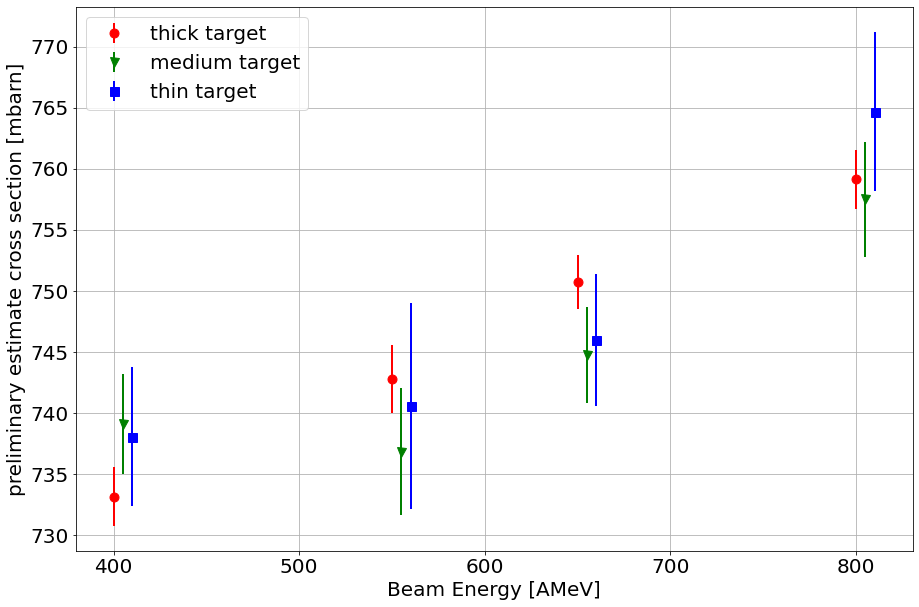

In [33]:
fig, ax = plt.subplots(figsize=(15,10))
#fig.tight_layout()


## whithout geo correction , in gray
energy = [400,550,650,800]
ax.errorbar(energy,cc_cs_geo_thick_f,yerr=cc_geo_error_thick_f,label="thick target",color='red',marker="o",fmt="o",alpha=1,elinewidth=2,markersize=9)

energy = [405,555,655,805]
ax.errorbar(energy,cc_cs_geo_medium_f,yerr=cc_geo_error_medium_f,label="medium target",color='green',marker="v",fmt="o",alpha=1,elinewidth=2,markersize=9)

energy = [410,560,660,810]
ax.errorbar(energy,cc_cs_geo_thin_f,yerr=cc_geo_error_thin_f,label="thin target",color='blue',marker="s",fmt="o",alpha=1,elinewidth=2,markersize=9)

ax.legend(fontsize=20,loc="upper left")
ax.grid()
ax.tick_params(labelsize=20)
ax.set_xlabel("Beam Energy [AMeV]",fontsize=20)
ax.set_ylabel("preliminary estimate cross section [mbarn]",fontsize=20)
#ax.set_title("Charge Changing Cross Section - Geometric Corrections")
#ax.set_ylim(740,890)
plt.savefig("charge_changing_cross_sec_prelim_no_geo_corr.png",dpi=300)

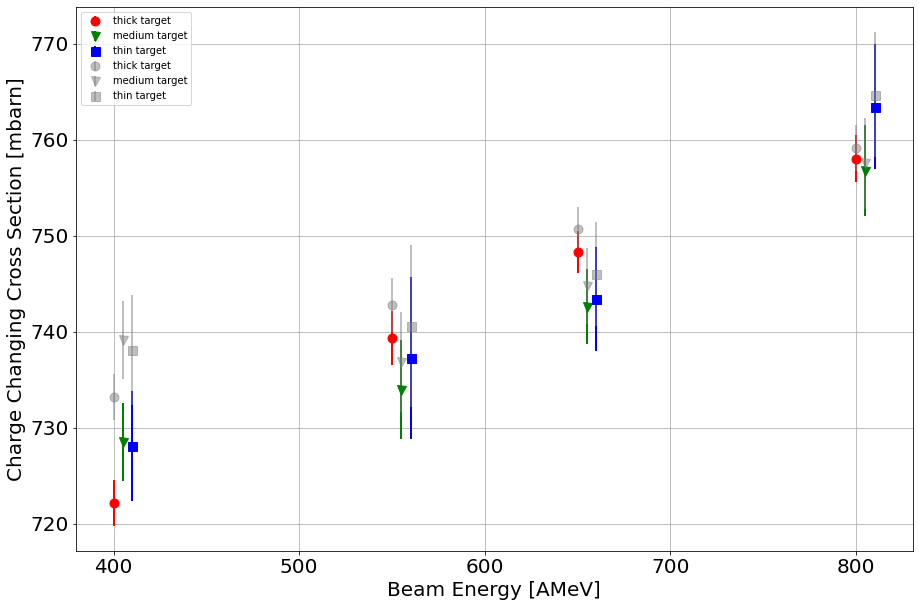

In [9]:
fig, ax = plt.subplots(figsize=(15,10))
#fig.tight_layout()
energy = [400,550,650,800]
ax.errorbar(energy,cc_cs_geo_thick,yerr=cc_geo_error_thick,label="thick target",color='red',marker="o",fmt="o",elinewidth=2,markersize=9)

energy = [405,555,655,805]
ax.errorbar(energy,cc_cs_geo_medium,yerr=cc_geo_error_medium,label="medium target",color='green',marker="v",fmt="o",elinewidth=2,markersize=9)

energy = [410,560,660,810]
ax.errorbar(energy,cc_cs_geo_thin,yerr=cc_geo_error_thin,label="thin target",color='blue',marker="s",fmt="o",elinewidth=2,markersize=9)

## whithout geo correction , in gray
energy = [400,550,650,800]
ax.errorbar(energy,cc_cs_geo_thick_f,yerr=cc_geo_error_thick_f,label="thick target",color='gray',marker="o",fmt="o",alpha=0.5,elinewidth=2,markersize=9)

energy = [405,555,655,805]
ax.errorbar(energy,cc_cs_geo_medium_f,yerr=cc_geo_error_medium_f,label="medium target",color='gray',marker="v",fmt="o",alpha=0.5,elinewidth=2,markersize=9)

energy = [410,560,660,810]
ax.errorbar(energy,cc_cs_geo_thin_f,yerr=cc_geo_error_thin_f,label="thin target",color='gray',marker="s",fmt="o",alpha=0.5,elinewidth=2,markersize=9)

ax.legend()
ax.grid()
ax.tick_params(labelsize=20)
ax.set_xlabel("Beam Energy [AMeV]",fontsize=20)
ax.set_ylabel("Charge Changing Cross Section [mbarn]",fontsize=20)
#ax.set_title("Charge Changing Cross Section - Geometric Corrections")
#ax.set_ylim(740,890)
plt.savefig("charge_changing_cross_sec_geo_cut_corr_flipping.png",dpi=300)

### save results and errors as file

In [28]:

# Define dictionaries for each target thickness
thin_dict = {
    400: "0179_0001",
    550: "0099_0001",
    650: "0126_0001",
    800: "0166_0001"
}

medium_dict = {
    400: "0181_0001",
    550: "0101_0001",
    650: "0127_0001",
    800: "0168_0001"
}

thick_dict = {
    400: "0183_0001",
    550: "0103_0001",
    650: "0130_0001",
    800: "0170_0001"
}

extra_dict = {
    400: "0333_0001",
    550: "0344_0001",
    650: "0355_0001",
    800: "0366_0001"
}

# Mapping thickness to corresponding dictionary
thickness_map = {
    "thin": thin_dict,
    "medium": medium_dict,
    "thick": thick_dict,
    "extra": extra_dict
}
thickness_code = {
    "thin": "c_54",
    "medium": "c_1086",
    "thick": "c_2198",
    "extra": "extra"    
}

# Function to create the DataFrame
def get_file_cross_sec(list_cs, list_err, target_thickness):
    d = {'datatype': [], 'targettype': [], "RunID": [], "energy": [], "cross_sec": [], "error": []}
    df = pd.DataFrame(data=d)
    energy_vals = [400, 550, 650, 800]
    
    # Choose correct dictionary
    try:
        selected_dict = thickness_map[target_thickness]
    except KeyError:
        raise ValueError(f"Invalid target_thickness: {target_thickness}. Must be one of {list(thickness_map.keys())}")
    
    for i, ene in enumerate(energy_vals):
        runid = selected_dict[ene]
        df = df.append({
            "datatype": "exp",
            "targettype": thickness_code[target_thickness],
            "RunID": runid,
            "energy": ene,
            "cross_sec": list_cs[i],
            "error": list_err[i]
        }, ignore_index=True)
        
    return df
         
                
df_corr_thin = get_file_cross_sec(cc_cs_geo_thin,cc_geo_error_thin,"thin")  
df_corr_medium = get_file_cross_sec(cc_cs_geo_medium,cc_geo_error_medium,"medium")
df_corr_thick = get_file_cross_sec(cc_cs_geo_thick,cc_geo_error_thick,"thick")
df_all = pd.concat([df_corr_thin, df_corr_medium, df_corr_thick], ignore_index=True)   
print(df_all)
df_all.to_csv("geo_corr_output_cc_cs_final.txt", sep='\t', index=False, header=False)


   datatype targettype      RunID  energy   cross_sec     error
0       exp       c_54  0179_0001   400.0  728.084200  5.699962
1       exp       c_54  0099_0001   550.0  737.263608  8.417064
2       exp       c_54  0126_0001   650.0  743.377688  5.432285
3       exp       c_54  0166_0001   800.0  763.429594  6.521361
4       exp     c_1086  0181_0001   400.0  728.489026  4.083116
5       exp     c_1086  0101_0001   550.0  733.961162  5.174965
6       exp     c_1086  0127_0001   650.0  742.576507  3.914176
7       exp     c_1086  0168_0001   800.0  756.778679  4.704268
8       exp     c_2198  0183_0001   400.0  722.164844  2.413405
9       exp     c_2198  0103_0001   550.0  739.347207  2.783232
10      exp     c_2198  0130_0001   650.0  748.301557  2.195432
11      exp     c_2198  0170_0001   800.0  758.005555  2.423464


#### this is just to plot the correction factors

0     0.000175
1     0.000226
2     0.000051
3     0.000023
4     0.000287
5     0.000207
6     0.000080
7     0.000034
8     0.000113
9     0.000211
10    0.000039
11    0.000020
12    0.000054
13    0.000234
14    0.000022
15    0.000018
Name: corr_error, dtype: float64
['c_1086' 'c_2198' 'c_54' 'empty']


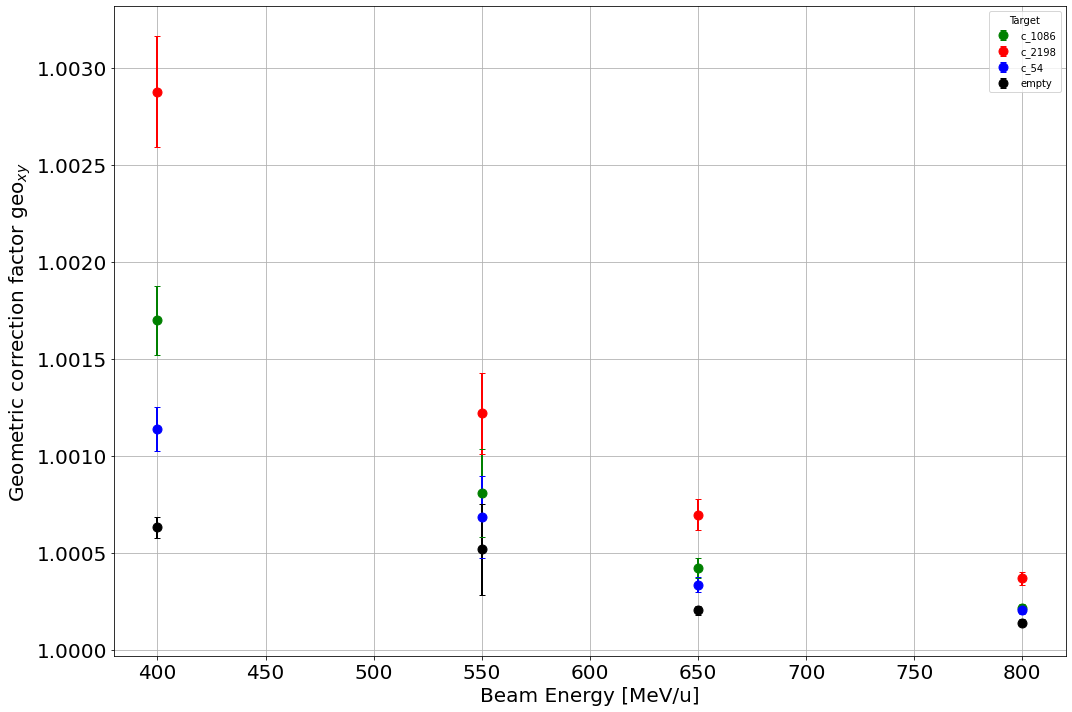

In [10]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))

df_corr_factors = pd.read_csv("geo_corr_flipping/two_sigma_tot_comb_geo_corr.txt",sep='\t',names=["datatype","targettype","RunID","energy","x_corr_min","x_corr_max","y_corr_min","y_corr_max"])
df_corr_factors["x_mean"] = 0.5* (df_corr_factors["x_corr_min"] + df_corr_factors["x_corr_max"])
df_corr_factors["y_mean"] = 0.5* (df_corr_factors["y_corr_min"] + df_corr_factors["y_corr_max"])
df_corr_factors["x_err"] = abs(0.5* (df_corr_factors["x_corr_min"] - df_corr_factors["x_corr_max"]))
df_corr_factors["y_err"] = abs(0.5* (df_corr_factors["y_corr_min"] - df_corr_factors["y_corr_max"]))
df_corr_factors["tot_corr"] = df_corr_factors["x_mean"]*df_corr_factors["y_mean"]
#df_corr_factors["corr_error"] = (np.power(df_corr_factors["x_mean"] * 0.5* (df_corr_factors["y_corr_min"] - df_corr_factors["y_corr_max"]),2) + np.power(df_corr_factors["y_mean"] * 0.5* (df_corr_factors["x_corr_min"] - df_corr_factors["x_corr_max"]),2))
df_corr_factors["corr_error"] = np.sqrt(np.power(df_corr_factors["x_mean"]*df_corr_factors["y_err"],2)+np.power(df_corr_factors["y_mean"]*df_corr_factors["x_err"],2))
print(df_corr_factors["corr_error"])

targets = df_corr_factors["targettype"].unique()
print(targets)
colors = ["green","red","blue","black"]
#colors = sns.color_palette("tab10", len(targets))  # or use your own mapping
color_map = dict(zip(targets, colors))

for target in targets:
    subset = df_corr_factors[df_corr_factors["targettype"] == target]
    ax.errorbar(
        subset["energy"],
        subset["tot_corr"],
        yerr=subset["corr_error"],
        fmt='o',
        label=target,
        color=color_map[target],
        capsize=3,
        elinewidth=2,
        markersize=9
    )
    
ax.grid(True)
ax.tick_params(labelsize=20)
ax.set_xlabel("Beam Energy [MeV/u]",fontsize=20)
ax.set_ylabel(r'Geometric correction factor geo$_{xy}$',fontsize=20)
#ax.set_title("Charge-Changing Cross Section vs Beam Energy")
ax.legend(title="Target")
ax.grid(True)

plt.tight_layout()
#plt.show()
plt.savefig("geo_corr_factors_flipping.png",dpi=300)
